In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.mlab as mlab

import types as types

import sys as sys
import os as os
sys.path.append('scripts27/')
sys.path.append('scripts27/gauss_mix')

import pyglet as pgl
import numpy as np

from main import Main
import gmix_model as gmix
import gmix_sample_mixture as smpl
import graph_NPZ as graph_highD

Loading chipmunk for Darwin (64bit) [/Users/azane/GitRepo/spider/venv/lib/python2.7/site-packages/pymunk/libchipmunk.dylib]


In [2]:
main = Main()
pgl.app.run()

In [3]:
s_x, s_t = gmix.get_xt_from_npz('data/spi_data.npz', True)

rand_x = np.random.random_sample(size=(1000, main.space.expHQ._xDim))
rand_x *= np.sum((main.space.expHQ._xRange*np.array([[[-1,1]]])), axis=2)
rand_x += np.expand_dims(main.space.expHQ._xRange[:,0],0)

_, pv_v, pv_c, pv_t, pv_s, pv_tests = main.space.expHQ.graph_space(s_x)
pv_v = np.expand_dims(pv_v, 1)

_, rand_pv_v, rand_pv_c, _, rand_pv_s, rand_pv_tests = main.space.expHQ.graph_space(rand_x)
rand_pv_v = np.expand_dims(rand_pv_v, 1)

main.space.expModel.build_graph()
#m, v, u = main.space.expModel.get_xmvu()  # this retrieves from a session that isn't updated!
m, v, u = pv_tests[4], pv_tests[5], pv_tests[6]

rand_m, rand_v, rand_u = rand_pv_tests[4], rand_pv_tests[5], rand_pv_tests[6]

x, y = smpl.mixture_expectation(s_x, m, v, u) #set to gmm expectation
_, rand_y = smpl.mixture_expectation(rand_x, rand_m, rand_v, rand_u) #set to gmm expectation
x, y_smpl = smpl.sample_mixture(s_x, m, v, u) #set to gmm sample

In [4]:
c = pv_tests[7]
t = pv_tests[8]
s = pv_tests[9]

print c.shape
print t.shape
print s.shape

c = np.mean(c, 1)
t = np.squeeze(t)
s = np.mean(s, 1)

print c.shape
print t.shape
print s.shape

print (c+t+s).shape

(30000, 1)
(30000, 1)
(30000, 1)
(30000,)
(30000,)
(30000,)
(30000,)


In [5]:
#print pv_tests[10]

(1000, 6)
(1000, 1)


<IPython.core.display.Javascript object>


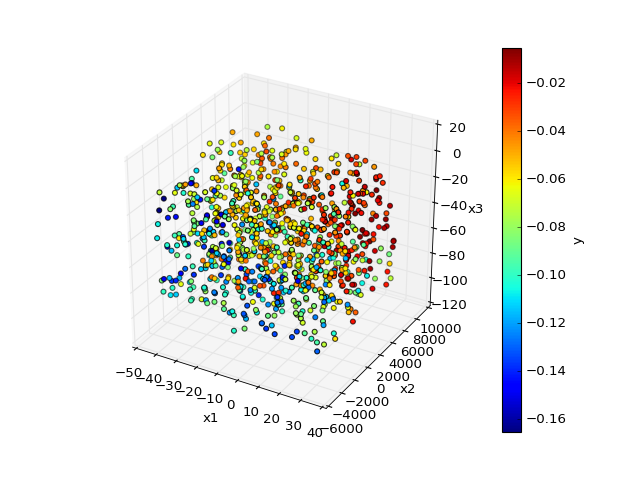

(<matplotlib.figure.Figure at 0x116de2ed0>,
  <matplotlib.axes._subplots.Axes3DSubplot at 0x116df4c10>])

In [6]:
xCols = [0,2,-1]
yLow = None#-0.05
yHigh = None#0.05
numPoints = 600

#point value
#fig, _ = graph_highD.graph3x1y(s_x, v, xCols=xCols,
#                      sbpltLoc=221, numPoints=numPoints)
#graph_highD.graph3x1y(s_x, c, xCols=xCols, fig=fig,
#                      sbpltLoc=222, numPoints=numPoints)
#graph_highD.graph3x1y(s_x, t, xCols=xCols, fig=fig,
#                      sbpltLoc=223, numPoints=numPoints)
#graph_highD.graph3x1y(s_x, s, xCols=xCols, fig=fig,
#                      sbpltLoc=224, numPoints=numPoints)

#sensor sample
#graph_highD.graph3x1y(s_x, y_smpl, xCols=xCols, fig=None,
#                      sbpltLoc=111, numPoints=numPoints*2)
#sensor expecation

print rand_x.shape
print rand_y.shape

#graph_highD.graph3x1y(s_x, y, xCols=xCols,
#                      yLow=yLow, yHigh=yHigh, fig=None,
#                      sbpltLoc=111, numPoints=numPoints*2)

graph_highD.graph3x1y(rand_x, rand_y, xCols=xCols,
                      yLow=yLow, yHigh=yHigh, fig=None,
                      sbpltLoc=111, numPoints=numPoints*2)

#actual sensor
#graph_highD.graph3x1y(s_x, s_t, xCols=xCols,
#                      yLow=yLow, yHigh=yHigh, fig=None,
#                      sbpltLoc=111, numPoints=numPoints*2)

In [7]:
explorerSeries = np.array(main.space.expHQ._explorerSeries)
explorerGradients = np.array(main.space.expHQ._explorerGrads)
explorerVals = np.array(main.space.expHQ._explorerVals)
explorerBest = np.array(main.space.expHQ._explorerBest)

<IPython.core.display.Javascript object>


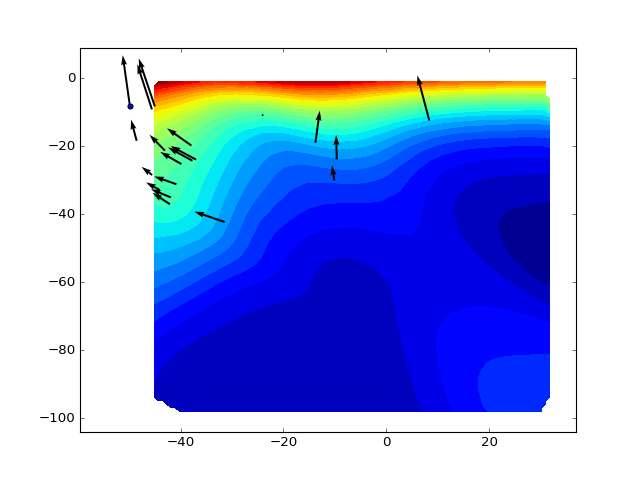

99%

In [8]:
def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    #stolen from http://stackoverflow.com/questions/18764814/make-contour-of-scatter
    xi = np.linspace(min(x), max(x), resX)
    yi = np.linspace(min(y), max(y), resY)
    Z = mlab.griddata(x, y, z, xi, yi, interp='linear')
    X, Y = np.meshgrid(xi, yi)
    return X, Y, Z

#ea is exploration animation
ea_numSkip = 1
ea_viewSection = (.4, .6)
ea_start = int(ea_viewSection[0]*explorerSeries.shape[0])
ea_end = int(ea_viewSection[1]*explorerSeries.shape[0])


ea_mapResolution = 2000 # m
ea_CFindices = np.array([0,-1])  # needs to be 2d for this to work.

ea_fig = plt.figure()

ea_artists = []

ea_EFmask = np.ones(explorerSeries[0,0,:].shape, dtype=bool)  # .shape == (xDim,)
ea_EFmask[ea_CFindices] = 0
ea_full = np.zeros(((ea_mapResolution,) + ea_EFmask.shape), dtype=float)  # .shape == (m, xDim)

ea_conRands = np.random.random_sample(size=(ea_mapResolution, ea_CFindices.size))  #.shape == (m, numCF)
ea_rangeSize = main.space.expHQ._xRange[ea_CFindices]*np.array([[-1,1]])  #.shape == (numCF, 2)
ea_conRands *= np.expand_dims(np.sum(ea_rangeSize, axis=1), 0)  # (m, numCF) * (1, numCF)
ea_conRands += np.expand_dims(main.space.expHQ._xRange[ea_CFindices,0], 0)  # (m, numCF) * (1, numCF)
assert ea_conRands.shape == (ea_mapResolution, ea_CFindices.size)

#For monkey fix below
def ea_setvisible(self,vis):
        for c in self.collections: c.set_visible(vis)
def ea_setanimated(self,anim):
        for c in self.collections: c.set_animated(anim)
####

#TEMP get half explorers for two kinds. dkwig90101kdnfko
#ea_numE = explorerSeries.shape[1]
#ea_half = int(ea_numE/2)
#/TEMP

ea_testHold = None

for i in range(ea_start,ea_end,ea_numSkip):
    ea_completion = ((float(i)/float(explorerSeries.shape[0]))-ea_viewSection[0])/(ea_viewSection[1]-ea_viewSection[0])
    ea_completion = int(100*ea_completion)
    sys.stdout.write("\r%d%%" % ea_completion)
    sys.stdout.flush()
    
    #set the values for all the explorers
    ea_full[:,ea_EFmask] = explorerSeries[i,0,ea_EFmask]  # set environmentals  (m, xDim)[:,numEF] = (numEF,)
    ea_full[:,ea_CFindices] = ea_conRands  # set controls  (m, xDim)[:,numCF] = (m, numCF)
    
    _, ea_pv, ea_pc, ea_pt, ea_ps, _ = main.space.expHQ.graph_space(ea_full)
    
    
    X, Y, Z = grid(np.copy(ea_full[:,ea_CFindices[0]]), np.copy(ea_full[:,ea_CFindices[1]]), np.squeeze(ea_pv))
    
    #create artists
    ea_contour = plt.contourf(X, Y, Z, 30)
    ea_quiver = plt.quiver(explorerSeries[i,:,ea_CFindices[0]], explorerSeries[i,:,ea_CFindices[1]],
                       explorerGradients[(i-1),:,ea_CFindices[0]], explorerGradients[(i-1),:,ea_CFindices[1]],
                          pivot='tail', width=0.004)
    ea_best = plt.scatter(explorerBest[i,ea_CFindices[0]], explorerBest[i,ea_CFindices[1]])
    #TEMP dkwig90101kdnfko
    #ea_quiver = plt.quiver(explorerSeries[i,:ea_half,ea_CFindices[0]], explorerSeries[i,:ea_half,ea_CFindices[1]],
    #           explorerGradients[(i-1),:ea_half,ea_CFindices[0]], explorerGradients[(i-1),:ea_half,ea_CFindices[1]],
    #           pivot='tail', width=0.004)
    #ea_scatter = plt.scatter(explorerSeries[i,ea_half:,ea_CFindices[0]], explorerSeries[i,ea_half:,ea_CFindices[1]],
    #                        marker='*')
    #/TEMP
    
    
    ###Monkey Fix from
    #http://matplotlib.1069221.n5.nabble.com/Matplotlib-1-1-0-animation-vs-contour-plots-td18703.html
    ea_contour.set_visible = types.MethodType(ea_setvisible,ea_contour,None)
    #ea_contour.axes = plt.gca()
    ###End monkey fix
    ###Monkey Fix 2
    #adapted from monkey fix 1
    ea_contour.set_animated = types.MethodType(ea_setanimated,ea_contour,None)
    ea_contour.axes = plt.gca()
    ###
    
    ea_artists.append((ea_contour,ea_quiver,ea_best))

ea_ani = animation.ArtistAnimation(ea_fig, ea_artists, interval=50, repeat_delay=2000, blit=True)
#ea_ani.save('data/ea_test.mp4', metadata={'artist':'Andy'})

<IPython.core.display.Javascript object>


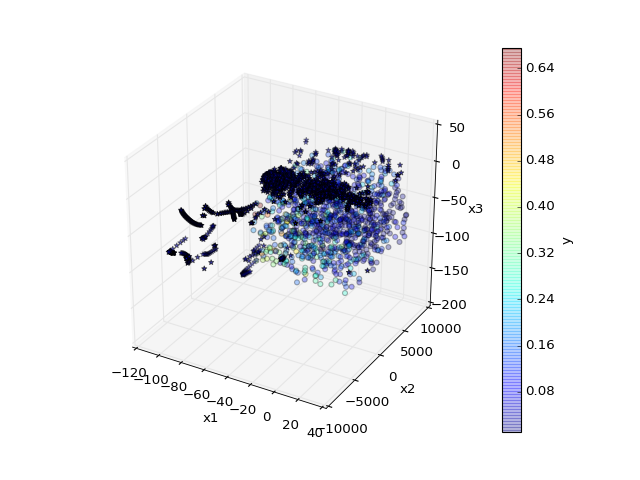

In [9]:
#fig, figStuff = graph_highD.graph3x1y(rand_x, rand_y, xCols=xCols, fig=None,
#                      sbpltLoc=111, numPoints=numPoints*2)

#pv
fig, figStuff = graph_highD.graph3x1y(rand_x, rand_pv_v, xCols=xCols, fig=None,
                      sbpltLoc=111, numPoints=numPoints*2, alpha=0.3)

figStuff[1].scatter(
                    xs = explorerBest[:,xCols[0]],
                    ys = explorerBest[:,xCols[1]],
                    zs = explorerBest[:,xCols[2]],
                    marker='*'
                    )
explorerID = 5
#figStuff[1].plot(
#                    xs = explorerSeries[:,explorerID,xCols[0]],
#                    ys = explorerSeries[:,explorerID,xCols[1]],
#                    zs = explorerSeries[:,explorerID,xCols[2]])

#------
#fig, figStuff = graph_highD.graph3x1y(rand_x, rand_pv_c, xCols=xCols, fig=None,
#                      sbpltLoc=111, numPoints=numPoints*2, alpha=0.3)

(1504, 20, 6)
(1504, 20, 6)
(1504, 20)
(1504,)
(1504,)


<IPython.core.display.Javascript object>


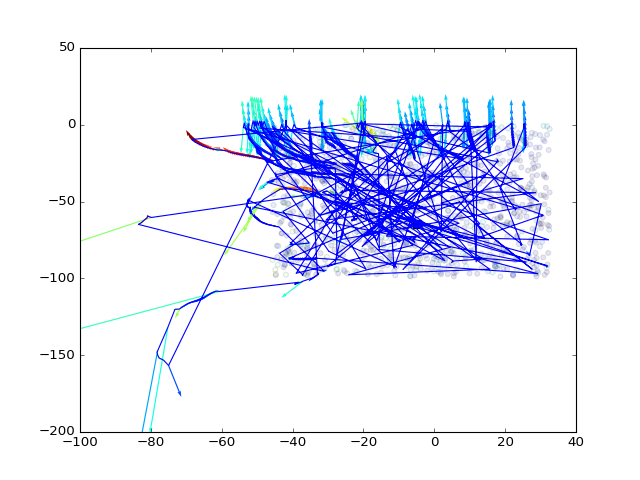

In [10]:
#explorerSeries.shape = (s, e, x)
#explorerVals.shape = (s, e)
print explorerGradients.shape
print explorerSeries.shape
print explorerVals.shape

print explorerSeries[:,explorerID,0].shape
print explorerVals[:,explorerID].shape

plt.figure()
plt.quiver(explorerSeries[:,explorerID,0], explorerSeries[:,explorerID,-1],
           explorerGradients[:,explorerID,0], explorerGradients[:,explorerID,-1],
           explorerVals[:,explorerID]
          )
plt.plot(explorerSeries[:,explorerID,0], explorerSeries[:,explorerID,-1])
#start point
plt.scatter(explorerSeries[0,explorerID,0], explorerSeries[0,explorerID,-1], marker='s', s=50)


#flattened point value graph over the features
plt.scatter(rand_x[:,0], rand_x[:,-1], c=rand_pv_v, alpha=0.1)

In [11]:
print pv_tests[3]

[[-0.018179    0.31248599  0.41273296  0.66202879 -0.85434502  0.23407029
   0.07214743  0.27295879  0.06079863 -0.03812854 -0.1154331   0.23177506
  -0.55793267  0.01575647 -0.68954825  0.90427572 -0.33965689  0.55321586
  -0.79349554 -0.24469662 -0.0157674  -0.42164892  0.07471658  0.08989979
  -0.26447368]
 [ 0.35713634  0.31315172  0.21870004 -0.6059857  -0.84384024  0.26071075
   0.17745839  0.05318673  0.14915872  0.10408507  0.01018039  0.28906894
  -0.99551564  0.35171133  0.9552778  -0.03408125 -0.3404434  -0.08136577
  -0.08895689 -0.83565015 -0.37693167  0.08415288  0.01647032  0.21461418
   0.63836682]
 [-0.20327312  0.26042432  0.48935357  0.62793046  0.18916772  0.11772167
  -0.20996204  0.22665687 -0.52170503 -0.35049954 -0.09212577 -0.26260814
  -0.11204749 -0.68932337 -0.55638278 -0.77479333 -0.46411014 -0.35942724
   0.51651412 -0.20478347  0.86518091 -0.27149299 -0.10588397 -0.01288145
  -0.87991017]
 [-0.23230699  0.2126451  -0.33591095 -0.10649401 -0.38713503  0.06

In [12]:
print y

[[-0.04690565]
 [-0.0480236 ]
 [-0.04879094]
 ..., 
 [-0.0310198 ]
 [-0.0318606 ]
 [-0.03223403]]


In [13]:
evalStr = [
    'calc_agg_grad_w1',
    'calc_agg_grad_b1',
    'calc_agg_grad_w2',
    'calc_agg_grad_b2',
    'calc_agg_grad_w3',
    'calc_agg_grad_b3',

    'v',
    'm',
    'u',
    
    'w1',
    'w2',
    'w3',
    'b1',
    'b2',
    'b3'
    ]
d = main.space.expModel.get_evals(evalStr)

print d['w1']
print d['b2']

[[ 0.21272983  0.26826483 -0.7262677   0.30954191  0.90739846 -0.54544228
  -0.6347279   0.28479323  0.23010673  0.35054496  0.5361796   0.09600502
  -0.05729331  0.34274516  0.07386605 -0.47099379  0.31998307 -0.13862754
   0.48086882 -0.95166153 -0.29898348  0.31387174 -0.40897903  0.1813961
  -0.99655932]
 [ 0.07129908 -0.50990075  0.80671489  0.1916557   0.55413741 -0.74503881
  -0.33448428 -0.64035356 -0.43643725  0.58969808 -0.35495523 -0.81433344
  -0.15089758 -0.6372087  -0.01081183  0.13049738 -0.25130758  0.10547169
   0.19155674  0.12658389 -0.3578988  -0.16096535 -0.80204481 -0.40634036
   0.86278135]
 [-0.59444332  0.56407493  0.17085442 -0.04184047 -0.32802081  0.14265655
  -0.12085094 -0.98326457 -0.20206547  0.07112959  0.58037853 -0.0120137
  -0.08138492  0.44259268 -0.10177619  0.90376228  0.01961082 -0.58518499
   0.20788951 -0.18483227 -0.13843577 -0.09998427  0.44979054 -0.26975301
  -0.53636646]
 [ 0.41174942  0.42882171 -0.2500039   0.51958442  0.39982432 -0.0127

In [14]:
np.ones((5,3,2)).shape[1:]

(3, 2)

In [15]:
x = main.space.expHQ.test_actuals['isolationGrad']
print x

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
